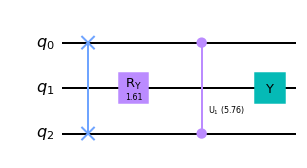

In [22]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import Operator
from qiskit.ignis.verification.tomography import state_tomography_circuits
from qiskit.opflow import One, Zero
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit import QuantumCircuit, QuantumRegister, transpile
import copy
from sympy import Matrix
import numpy as np
import sys  
sys.path.insert(0, '/Users/valerio/Documents/project_IBM_01/IBM_git/lib')
import utilities

N_qubits = 3

circ = random_circuit(num_qubits = N_qubits, depth = 2)
circ.draw(output='mpl')

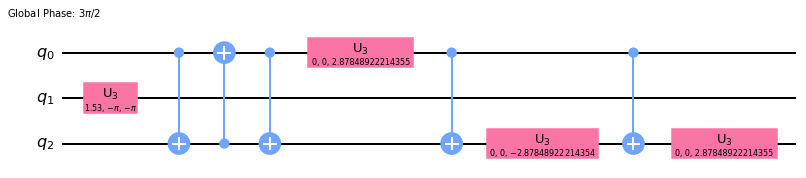

In [23]:
circ = transpile(circ, basis_gates=["cx","u3","id"])
circ.draw(output="mpl")

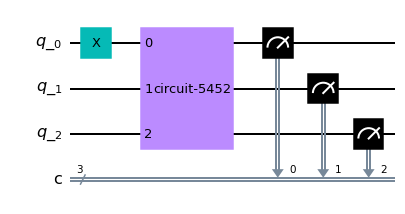

In [24]:
cal_circ_CIC, state_labels = utilities.get_calibration_circuits(circ, method="CIC")
cal_circ_CIC[1].draw(output="mpl")

In [25]:
tomo_circ = state_tomography_circuits(circ, circ.qregs)

In [26]:
from qiskit import IBMQ, execute
from qiskit.providers.aer import QasmSimulator

IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_noisy_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')

#################################################################
########################################### execute all the jobs
BACKEND = backend_sim_noisy_jakarta
shots = 20000

job_CIC=execute(cal_circ_CIC, backend = BACKEND, shots=shots)
job_tomography=execute(tomo_circ, backend = BACKEND, shots=shots)

ibmqfactory.load_account:WARNING:2022-05-25 10:37:03,589: Credentials are already in use. The existing account in the session will be replaced.


In [29]:
#################################################################
#################################### Mititgation of the raw results

# building the matrices
meas_fitter_CIC = CompleteMeasFitter(job_CIC.result(), state_labels=state_labels)
# copy the measured probability matrices.
U_tilde_CIC = meas_fitter_CIC.cal_matrix
# U_ideal is the unitary matrix of the circuit qc_U, we will use it for the CIC method.
U_ideal = Operator(circ)
# defining the tomography basis circuits.
qr_basi = QuantumRegister(N_qubits)
qc_basi = QuantumCircuit(qr_basi)
tomography_basis = state_tomography_circuits(qc_basi, qr_basi)

# compute the probability matrix of U_ideal and the inverse of it.
U_ideal_abs = np.abs(U_ideal)**2
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)
# built the calibration matrix in the computational basis for both CIC and NIC methods.
C_CIC = np.dot(U_tilde_CIC, U_ideal_abs_inv)
# building the fast tomography circuits calibration.
# next are computed the calibration matrices in all the tomography basis,
# and after are applyed to the raw result for both CIC and NIC.
raw_result = job_tomography.result()
CIC_result = copy.deepcopy(raw_result)
for i, basis in enumerate(tomography_basis):
    basis.remove_final_measurements()
    # building the unitary matrix of the basis and the inverse.
    base_matrix_amplitudes = Operator(basis)
    base_matrix_amplitudes_inverse = base_matrix_amplitudes.conjugate().transpose()
    # building the probability matrices.
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2
    # change the basis of the calibration matrices for NIC and CIC.
    C_basis_CIC = np.linalg.multi_dot([base_matrix, C_CIC,  base_matrix_inverse])
    #C_basis_CIC = np.abs(np.linalg.multi_dot([base_matrix_amplitudes, C_CIC,  base_matrix_amplitudes_inverse]))**2
    # changing the meas_fitter_SSD_CIC calibration matrix with the new calibration matrix. 
    meas_fitter_CIC_aus = copy.deepcopy(meas_fitter_CIC)
    meas_fitter_CIC_aus._tens_fitt.cal_matrices[0]=C_basis_CIC
    # computing the new counts for both the mitigation techniques
    old_counts=raw_result.get_counts(basis)
    new_counts_CIC = meas_fitter_CIC_aus.filter.apply(old_counts, method="least_squares")
    CIC_result.results[i].data.counts = new_counts_CIC

In [30]:
target_state = np.array(Operator(circ))[:,0]#(One^One^Zero).to_matrix()  # (|q_5,q_3,q_1> = |110>)
# compute the fidelity
fid_raw = utilities.fidelity_count(raw_result, tomo_circ, target_state)
fid_CIC = utilities.fidelity_count(CIC_result, tomo_circ, target_state)
# print the result
print(f"fidelity of raw results: {fid_raw}\nfidelity with CIC method: {fid_CIC}")


fidelity of raw results: 0.8898720764510505
fidelity with CIC method: 0.5007472179642963
